First, we're interested in calcuating the cavity pull \chi. The main idea here is that when the qubit is in the excited state, its resonant frequency shifts by 2\chi, so we can put the qubit in the excited state and measure the change in resonant frequency. Most of this code is straight from the textbook (which has procedures for defining a pi pulse and performing a frequency sweep). First, we find the rough qubit frequency in the ground state with a frequency sweep.

In [2]:
from qiskit.tools.jupyter import *
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds
    
backend_defaults = backend.defaults()
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += drive_pulse(drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job = backend.run(frequency_sweep_program)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Sampling time: 0.2222222222222222 ns
Qubit 0 has an estimated frequency of 4.974292353542467 GHz.
The sweep will go from 4.954292353542466 GHz to 4.994292353542466 GHz in steps of 1.0 MHz.


C:\Users\johnd\anaconda3\lib\site-packages\qiskit\pulse\pulse_lib\sample_pulse.py:153: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(samples), DriveChannel(0))`.
  DeprecationWarning)
C:\Users\johnd\anaconda3\lib\site-packages\qiskit\pulse\pulse_lib\pulse.py:49: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(array([5.49416668e-07+0.j, 1.65754813e-06+0.j, 2.77818493e-06+0.j, ...,
       2.77818493e-06+0.j, 1.65754813e-06+0.j, 5.49416668e-07+0.j]), name='freq_sweep_excitation_pulse'), DriveChannel(0))`.
  DeprecationWarning)


5ebc358defde610013460601
Job Status: job has successfully run


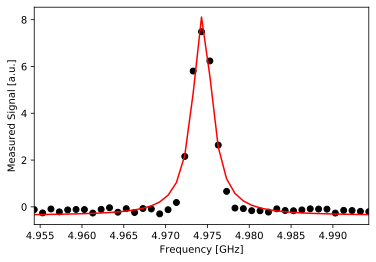

We've updated our qubit frequency estimate from 4.97429 GHz to 4.97439 GHz.


In [4]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds
%matplotlib inline
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [5, 4.975, 1, 0] # initial parameters for curve_fit
                                )

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

Now, we define a pi pulse, as in the next section of the textbook. We got better results using this pi pulse than the in-built pi pulse, which may be a result of the fact that it's somewhat imperfect, giving us some qubits in the ground state as well as the excited state. When using the in-built pi pulse, we got one peak in between the two peaks rather than two peaks.

In [5]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += rabi_pulse(drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)
    # Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)
print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

C:\Users\johnd\anaconda3\lib\site-packages\qiskit\pulse\pulse_lib\sample_pulse.py:153: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(samples), DriveChannel(0))`.
  DeprecationWarning)
C:\Users\johnd\anaconda3\lib\site-packages\qiskit\pulse\pulse_lib\pulse.py:49: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]), name='Rabi drive amplitude = 0.0'), DriveChannel(0))`.
  DeprecationWarning)
C:\Users\johnd\anaconda3\lib\site-packages\qiskit\pulse\pulse_lib\sample_pulse.py:153: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use:

5ebc358defde610013460601
Job Status: job has successfully run


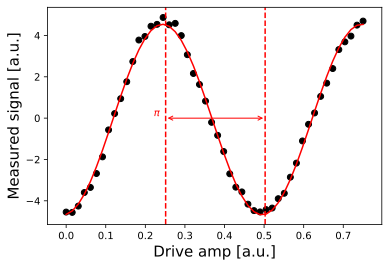

Pi Amplitude = 0.25132086906756934


In [6]:
rabi_results = job.result(timeout=120)
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.5, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

Next, we perform a frequency sweep that takes place only after a pi pulse, to put the qubit into the excited state. Since we expect \chi to be on the scale of 0.1 MHz, we perform the frequency sweep sampling points over only 1.3 MHz, in much smaller steps.

In [27]:
# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 1.3 MHz around the estimated frequency
frequency_span_Hz = 1.3 * MHz
# in steps of 0.037 MHz (producing 35 data points).
frequency_step_Hz = 0.037 * MHz

# We will sweep 0.65 MHz above and below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)
# Create the base schedule
# Start with pi pulse, then add drive pulse
schedule = pulse.Schedule(name='Frequency sweep')
schedule += pi_pulse(drive_chan)
schedule += drive_pulse(drive_chan) << schedule.duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job = backend.run(frequency_sweep_program)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

The sweep will go from 4.973642353542466 GHz to 4.974942353542466 GHz in steps of 0.037 MHz.


C:\Users\johnd\anaconda3\lib\site-packages\qiskit\pulse\pulse_lib\sample_pulse.py:153: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(samples), DriveChannel(0))`.
  DeprecationWarning)
C:\Users\johnd\anaconda3\lib\site-packages\qiskit\pulse\pulse_lib\pulse.py:49: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(array([4.60266248e-07+0.j, 1.38858812e-06+0.j, 2.32738617e-06+0.j, ...,
       2.32738617e-06+0.j, 1.38858812e-06+0.j, 4.60266248e-07+0.j]), name='pi_pulse'), DriveChannel(0))`.
  DeprecationWarning)
C:\Users\johnd\anaconda3\lib\site-packages\qiskit\pulse\pulse_lib\sample_pulse.py:153: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction d

5ebc63f772dc6900128cc57c
Job Status: job has successfully run


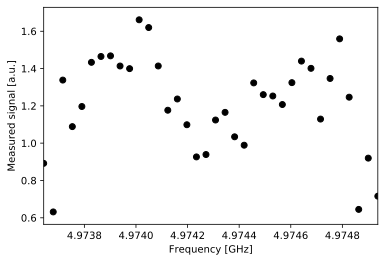

In [28]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds
%matplotlib inline
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

We see that there are two distinct peaks in the frequency sweep. This is because the qubit has a chance of decaying during the frequency sweep, which means that one of these peaks corresponds to the ground state and one corresponds to the excited state. This allows us to measure \chi directly from this graph, by fitting a sum of two Lorentzians. \chi is simply half the difference between their fitted frequencies (such that \chi is negative). Since we're only looking at a narrow range of the Lorentzians, the fit is finicky, so we choose starting values that should be close to the final answers so the fit converges.

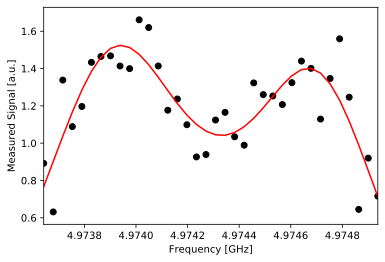

Chi =  -0.39873332590989463 MHz


In [29]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A1, A2, q_freq1, q_freq2, B1, B2, C: (A1 / np.pi) * (B1 / ((x - q_freq1)**2 + B1**2)) + (A2 / np.pi) * (B2 / ((x - q_freq2)**2 + B2**2)) + C,
                                 [0.0005, 0.0005, 4.974, 4.9746, 0.0001, 0.0001, 1] # initial parameters for curve_fit
                                )

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

A1, A2, qu_freq1, qu_freq2, B1, B2, C = fit_params
chi = -abs(qu_freq1-qu_freq2)*GHz/2 # make sure qubit freq is in Hz
print(f"Chi =  {chi / MHz} MHz")